In [1]:
import numpy as np
from statistics import mean
from math import exp, pi, atan
import matplotlib.pyplot as plt
from scipy.special import erf

In [2]:
# Define functions for working with the edge
def diff(sig, s):
    d = np.zeros(s)
    for i in range(s):
        if i == 0 or i == s-1:
            d[i] = 0
        else:
            d[i] = (sig[i+1] - sig[i-1]) / 2.
    return d

def normalize_diff(sig):
    s = sum(sig)
    return [i / s for i in sig]

def normalize_edge(sig):
    l = len(sig)
    v = sig[l-l//8:]
    p = mean(v)
    return [i / p for i in sig]

def find_index(val, ls):
    i = 0
    for j in ls:
        if j == val:
            return i
        else:
            i += 1
    return 0

In [3]:
# Define curve functions to fit

def logistic(k, le):
    y = []
    x0 = le // 2
    for x in range(le):
        v = 1 / (1 + exp(-k * (x - x0)))
        y.append(v)
    return y

def use_erf(a, le):
    y = []
    x0 = le // 2
    for x in range(le):
        y.append(0.5 * (1 + erf(a*(x-x0))))
    return y

def find_mse(orig, new):
    return mean(abs(a - b) for a, b in zip(orig, new))

In [4]:
# Import blurring methods
from BLUR import blur
from KERNEL import kernel

In [5]:
x = []
for i in range(512):
    if i < 256:
        x.append(0.)
    else:
        x.append(1.)
x = np.asarray(x).reshape(len(x), 1)

A = kernel(x.shape[0], 10)
b = list(blur(x, A, True, 0.012))

sig = []
for i in b:
    sig.append(float(i))

# Crop to just the edge
sig = sig[156:356]

In [6]:
# Monte Carlo Estimation for Error Minimization
n = 512
k = [np.random.random() for i in range(n)]

nsig = normalize_edge(sig)

mses = [find_mse(nsig, logistic(term, len(sig))) for term in k]
m = find_index(min(mses), mses)

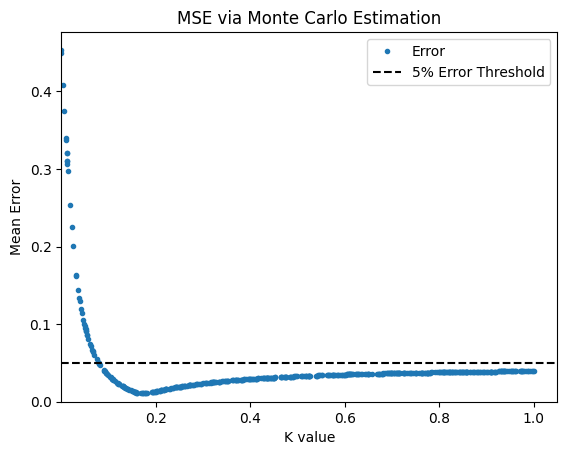

In [7]:
plt.plot(k, mses, '.')
#plt.vlines(k[m], 0, 1, [0.75, 0.3, 0.1], linestyles='dashed')
plt.hlines(0.05, 0, 100, [0, 0, 0], linestyles='dashed')
plt.title("MSE via Monte Carlo Estimation")
plt.xlabel("K value")
plt.ylabel("Mean Error")
plt.xlim([min(k)-min(k)*0.05, max(k)+max(k)*0.05])
plt.ylim([0, max(mses)+max(mses)*0.05])
plt.legend(["Error", "5% Error Threshold"])
plt.show()

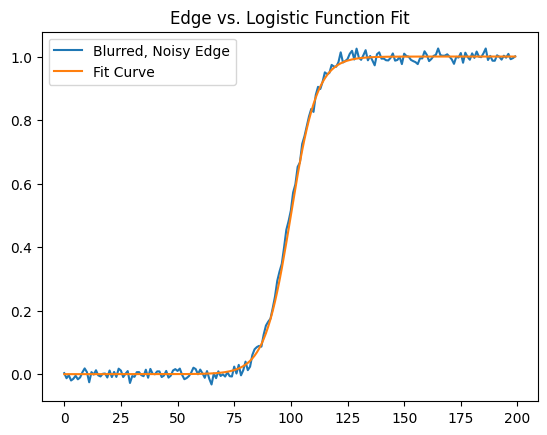

In [8]:
# This doesn't work for monte carlo method, but I'm keeping it here as ref
# m = min(enumerate(mses), key=lambda a: a[1])[0] / 100
plt.plot(nsig)
plt.plot(logistic(k[m], len(nsig)))
plt.title("Edge vs. Logistic Function Fit")
plt.legend(["Blurred, Noisy Edge", "Fit Curve"])
plt.show()

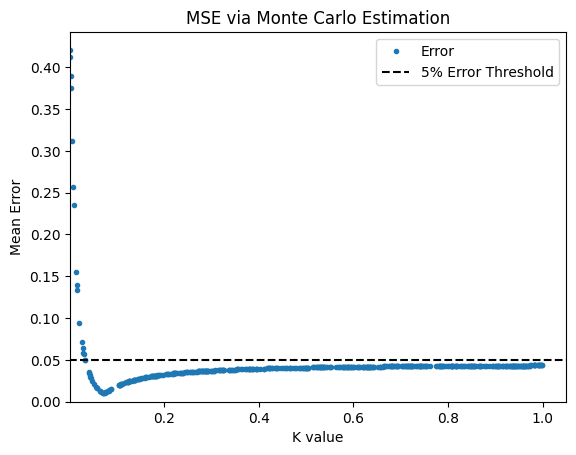

In [9]:
# Monte Carlo Estimation for Error Minimization
n = 512
k = [np.random.random() for i in range(n)]

mses = [find_mse(nsig, use_erf(term, len(sig))) for term in k]
m = find_index(min(mses), mses)

plt.plot(k, mses, '.')
plt.hlines(0.05, 0, 100, [0, 0, 0], linestyles='dashed')
plt.title("MSE via Monte Carlo Estimation")
plt.xlabel("K value")
plt.ylabel("Mean Error")
plt.xlim([min(k)-min(k)*0.05, max(k)+max(k)*0.05])
plt.ylim([0, max(mses)+max(mses)*0.05])
plt.legend(["Error", "5% Error Threshold"])
plt.show()

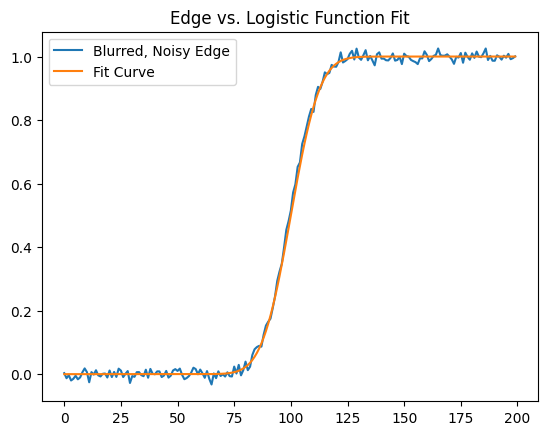

In [10]:
plt.plot(nsig)
plt.plot(use_erf(k[m], len(nsig)))
plt.title("Edge vs. Logistic Function Fit")
plt.legend(["Blurred, Noisy Edge", "Fit Curve"])
plt.show()

In [11]:
from KERNEL import est_kernel
from TKV_REG import tkv_regularize
from TV_REG import tv_regularize
from GCV import run_gcv

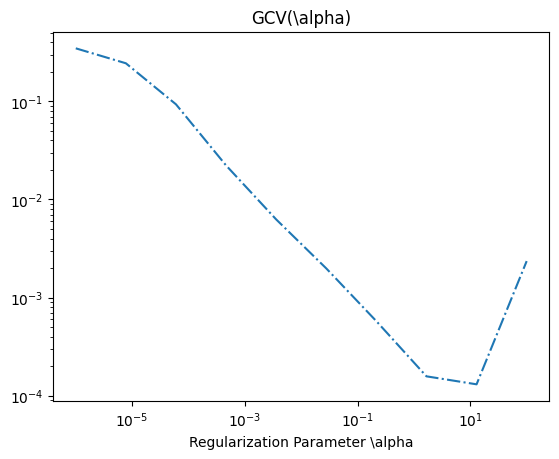

In [12]:
ds = diff(use_erf(k[m], len(nsig)), len(nsig))
# Makes sure that the area under the curve is 1/2.
ke = [i / 2 for i in normalize_diff(ds[len(ds)//2:])]
A = est_kernel(len(nsig), ke)
orig, err = run_gcv(A, np.array(nsig).reshape((len(nsig), 1)), tv_regularize, 10)

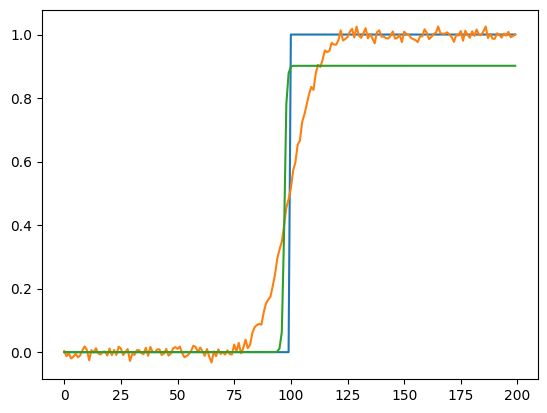

In [15]:
plt.plot(x[156:356])
plt.plot(nsig)
plt.plot(orig)
plt.show()